In [15]:
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
colors = ("#8E063B","#B9534C","#DA8459","#EEAB65","#F6C971","#F1DE81","#E2E6BD")[::-1]
events_cmap= ListedColormap(colors)

In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [167]:
df= pd.read_csv('merged_v0.42.csv', index_col='ID')

/home/allen/Documents/Programs/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (1,2,8,10,13,14,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
gdf= gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.LON, df.LAT))

In [117]:
world['events']= world.apply(lambda x: len(gdf[gdf.COUNTRY==x['name']]), axis=1)

In [119]:
world['events']= np.log10(world['events'])

/home/allen/Documents/Programs/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [122]:
world= world[~np.isinf(world.events)]

/home/allen/Documents/Programs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Use the colorbar set_ticks() method instead.
  # This is added back by InteractiveShellApp.init_path()


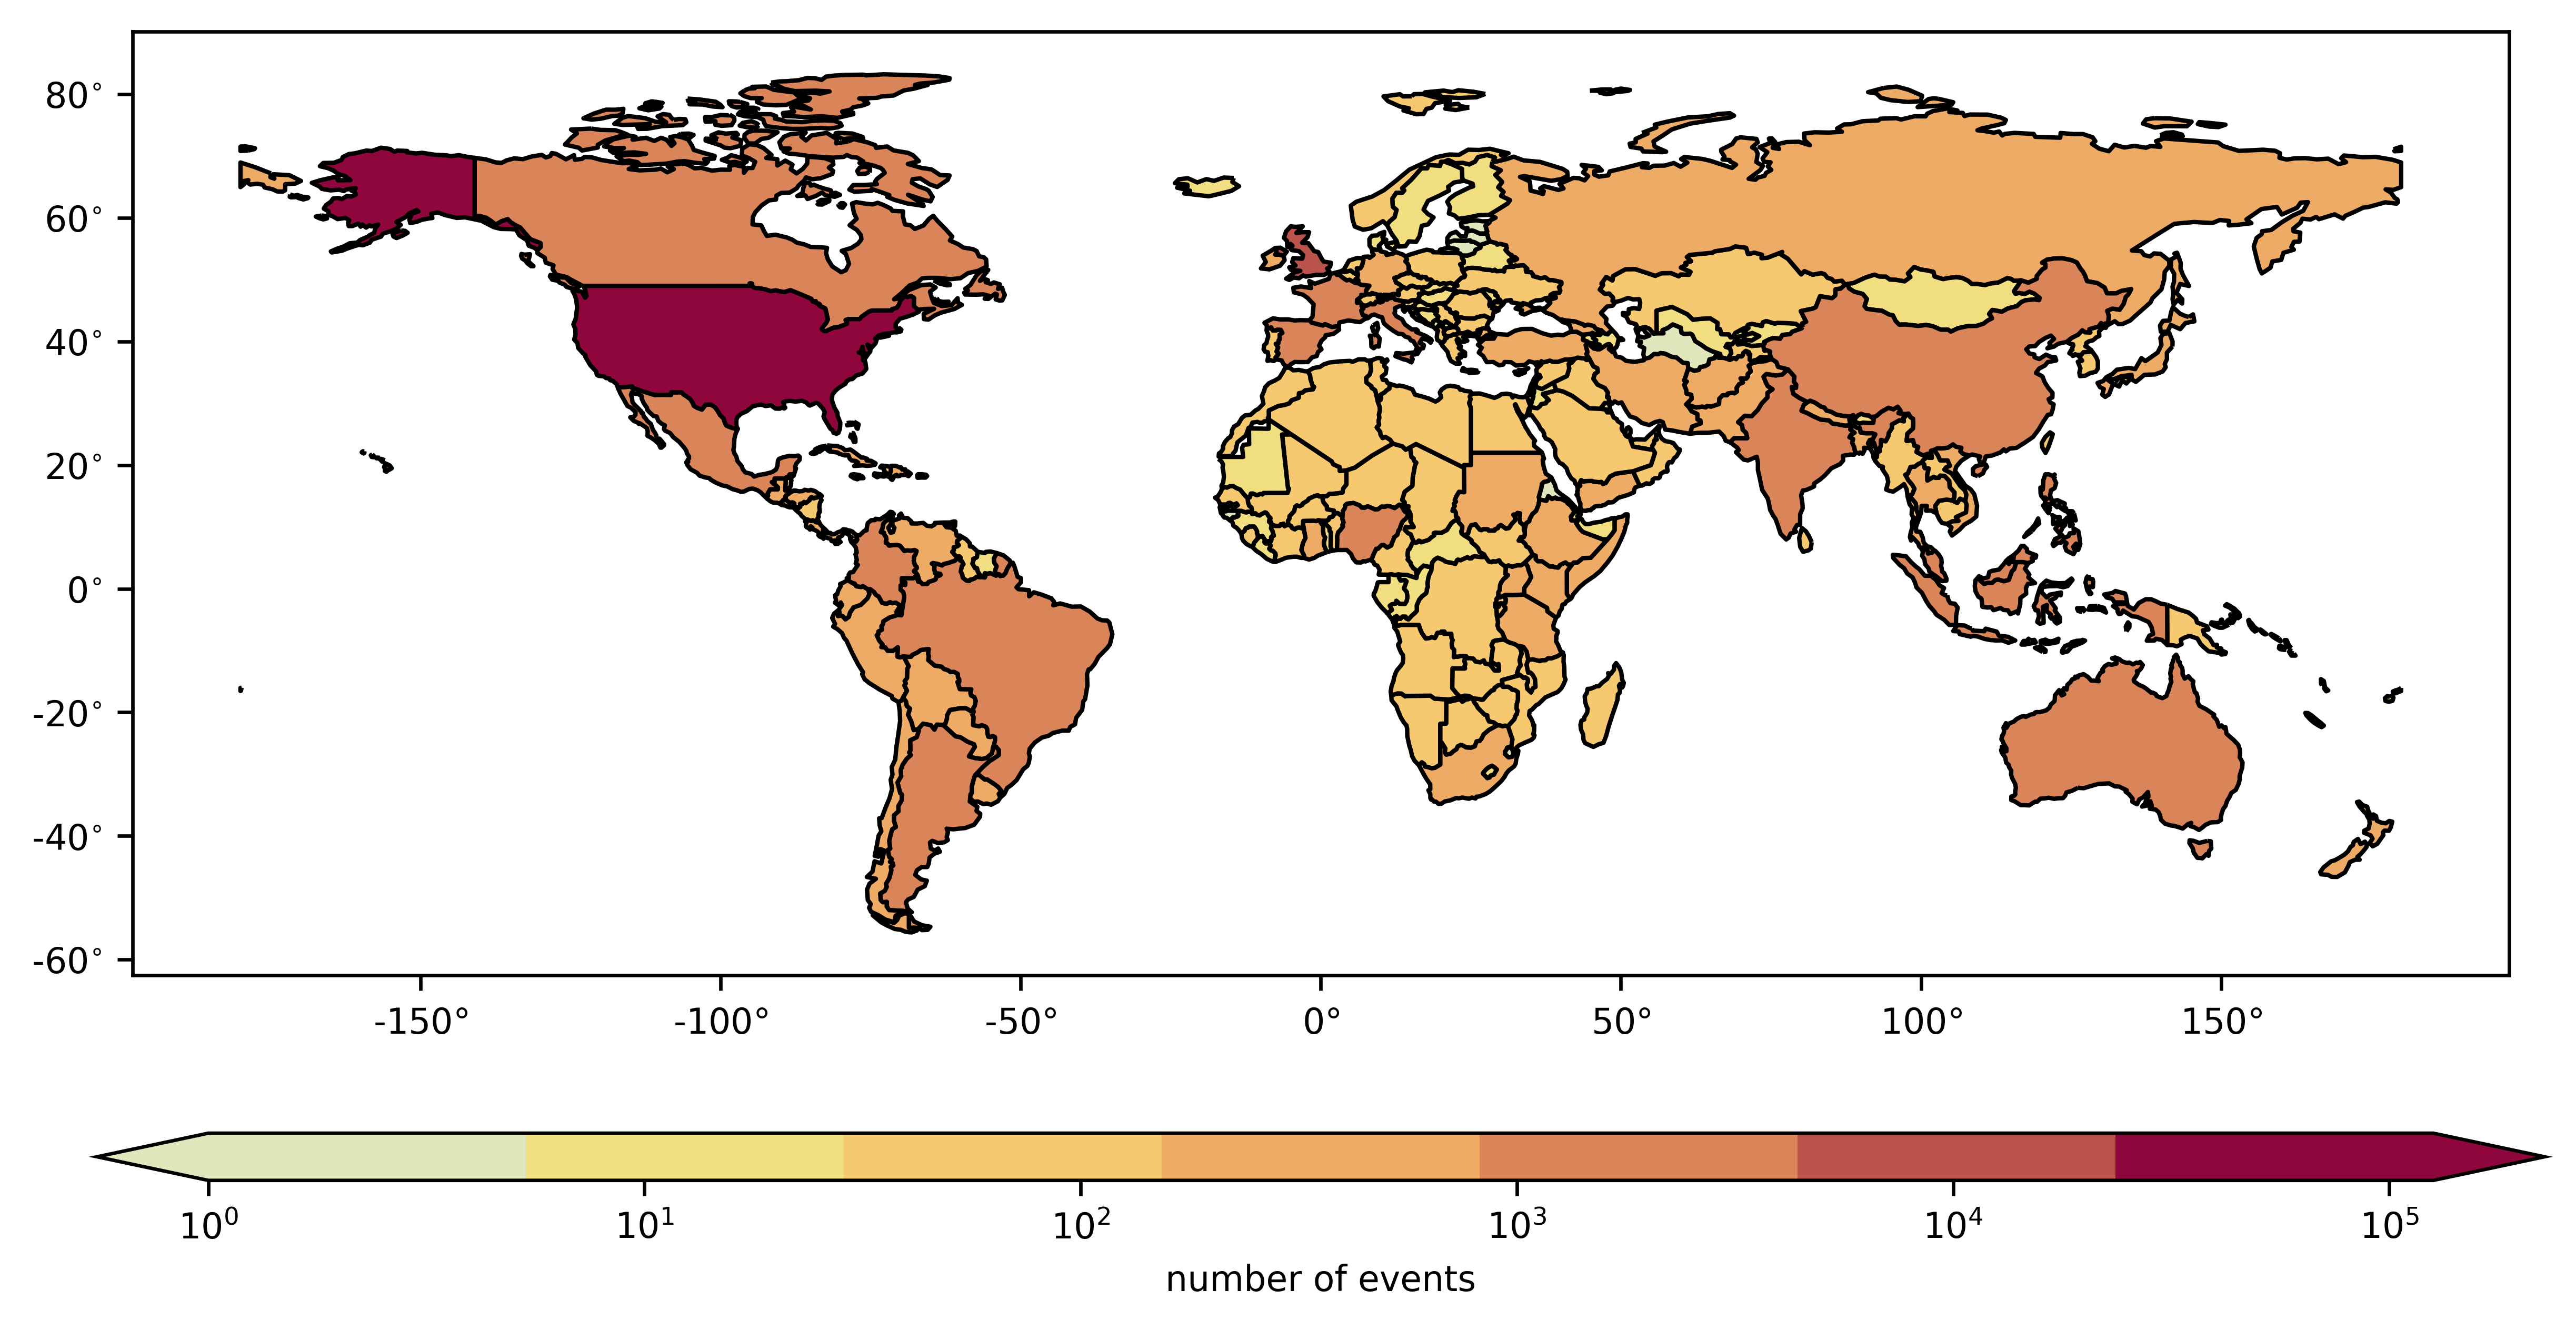

In [123]:
fig= plt.figure(figsize=(10,5))
ax= fig.add_subplot(111)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)

view= world.plot(column='events',ax=ax, cmap=events_cmap, legend=True, cax=cax, edgecolor='black',
           legend_kwds={'label': "number of events",
                        'orientation': "horizontal",
                       "ticks": np.arange(6),
                       "extend": 'both'})
cax.set_xticks(np.arange(6))
cax.set_xticklabels(['$10^%d$'%i for i in range(6)]);
ax.set_xticks(np.arange(-150,200,50))
ax.set_xticklabels(['%d$\degree$'%i for i in range(-150,200,50)])
ax.set_yticks(np.arange(-60,100,20))
ax.set_yticklabels(['%d$^{\circ}$'%i for i in range(-60,100,20)]);

In [124]:
fig.savefig('src/global_events.png', dpi=500)

In [7]:
import ee

In [8]:
ee.Initialize()

In [11]:
states= ee.FeatureCollection('TIGER/2016/States').getInfo()

In [12]:
US_states= gpd.GeoDataFrame()

In [13]:
from shapely.geometry import Polygon, MultiPolygon

In [183]:
US_states= gpd.GeoDataFrame()
for i,fea in enumerate(states['features']):
#     if fea['properties']['NAME'] not in ['American Samoa', 'Puerto Rico',
#                                          'United States Virgin Islands',
#                                         'Commonwealth of the Northern Mariana Islands','Guam',
#                                         'Rhode Island', 'Alaska', 'Hawaii']:
    US_states.loc[i,'name']= fea['properties']['NAME']
    US_states.loc[i,'type']= fea['geometry']['type']
    if fea['geometry']['type']=='Polygon':
        US_states.loc[i,'geometry']= Polygon(fea['geometry']['coordinates'][0])
    elif fea['geometry']['type']=='MultiPolygon':
        US_states.loc[i,'geometry']= gpd.GeoSeries([MultiPolygon([Polygon(poly[0]) for poly in fea['geometry']['coordinates']])]).values
    elif fea['geometry']['type']=='GeometryCollection':
        for each in fea['geometry']['geometries']:
            if each['type']=='Polygon':
                US_states.loc[i,'geometry']= Polygon(each['coordinates'][0])


In [180]:
def countByStates(state, country):
    masks= gdf[gdf.COUNTRY==country].geometry.within(state.geometry)
    _gdf= gdf[gdf.COUNTRY==country][masks]
    
    return len(_gdf)

def getIndByStates(state, country):
    masks= gdf[gdf.COUNTRY==country].geometry.within(state.geometry)
    
    return gdf[gdf.COUNTRY==country][masks].index.values

In [91]:
US_states['events']= US_states.apply(countByStates, axis=1)

In [96]:
US_states['events_log']= np.log10(US_states['events'])

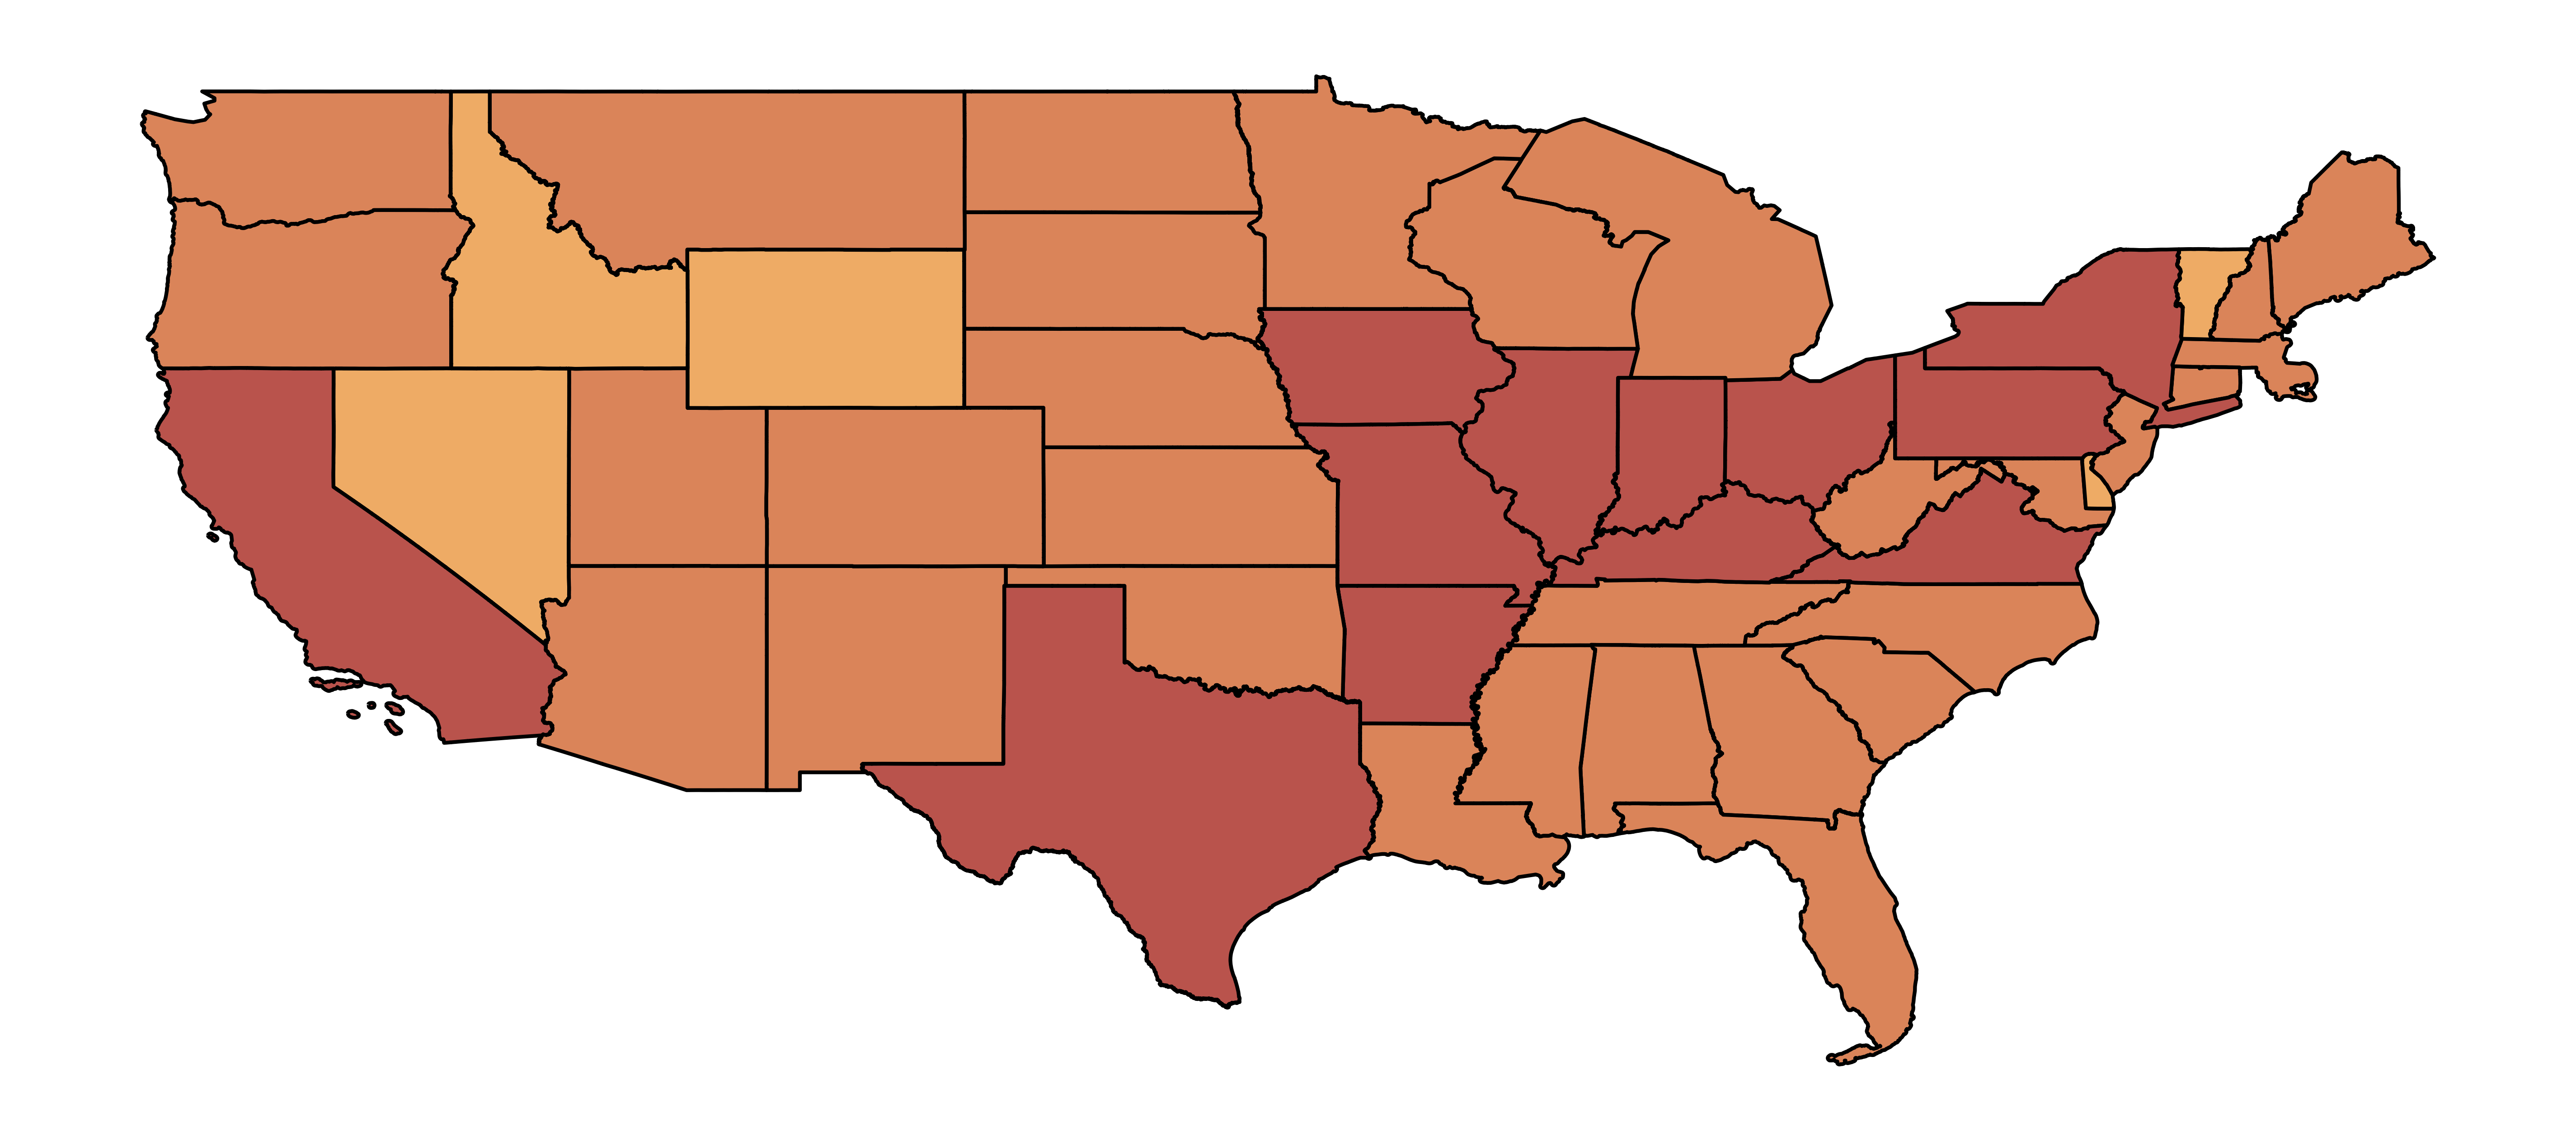

In [125]:
fig= plt.figure(figsize=(12,6))
ax= fig.add_subplot(111)
US_states.plot(column='events_log', ax=ax, cmap=events_cmap,edgecolor='black',
               vmin=0, vmax=5)
ax.axis('off');

In [126]:
fig.savefig('src/US_floods_states.png', dpi=500)

In [101]:
US_states.to_file('US_floods_states')

In [186]:
# clean states

IDs= US_states.apply(getIndByStates, axis=1, country='United States of America')
for i,ids in enumerate(IDs):
    df.loc[ids, 'STATE']= US_states.loc[i, 'name']

# Indian states

In [103]:
Ind_states= gpd.read_file('Indian states/Indian_States.shp')

In [109]:
Ind_states['events']= Ind_states.apply(countByStates, axis=1,country='India')

In [127]:
Ind_states['events_log']= np.log10(Ind_states['events'])

/home/allen/Documents/Programs/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [133]:
Ind_states.loc[Ind_states.events==0, 'events_log']= np.nan

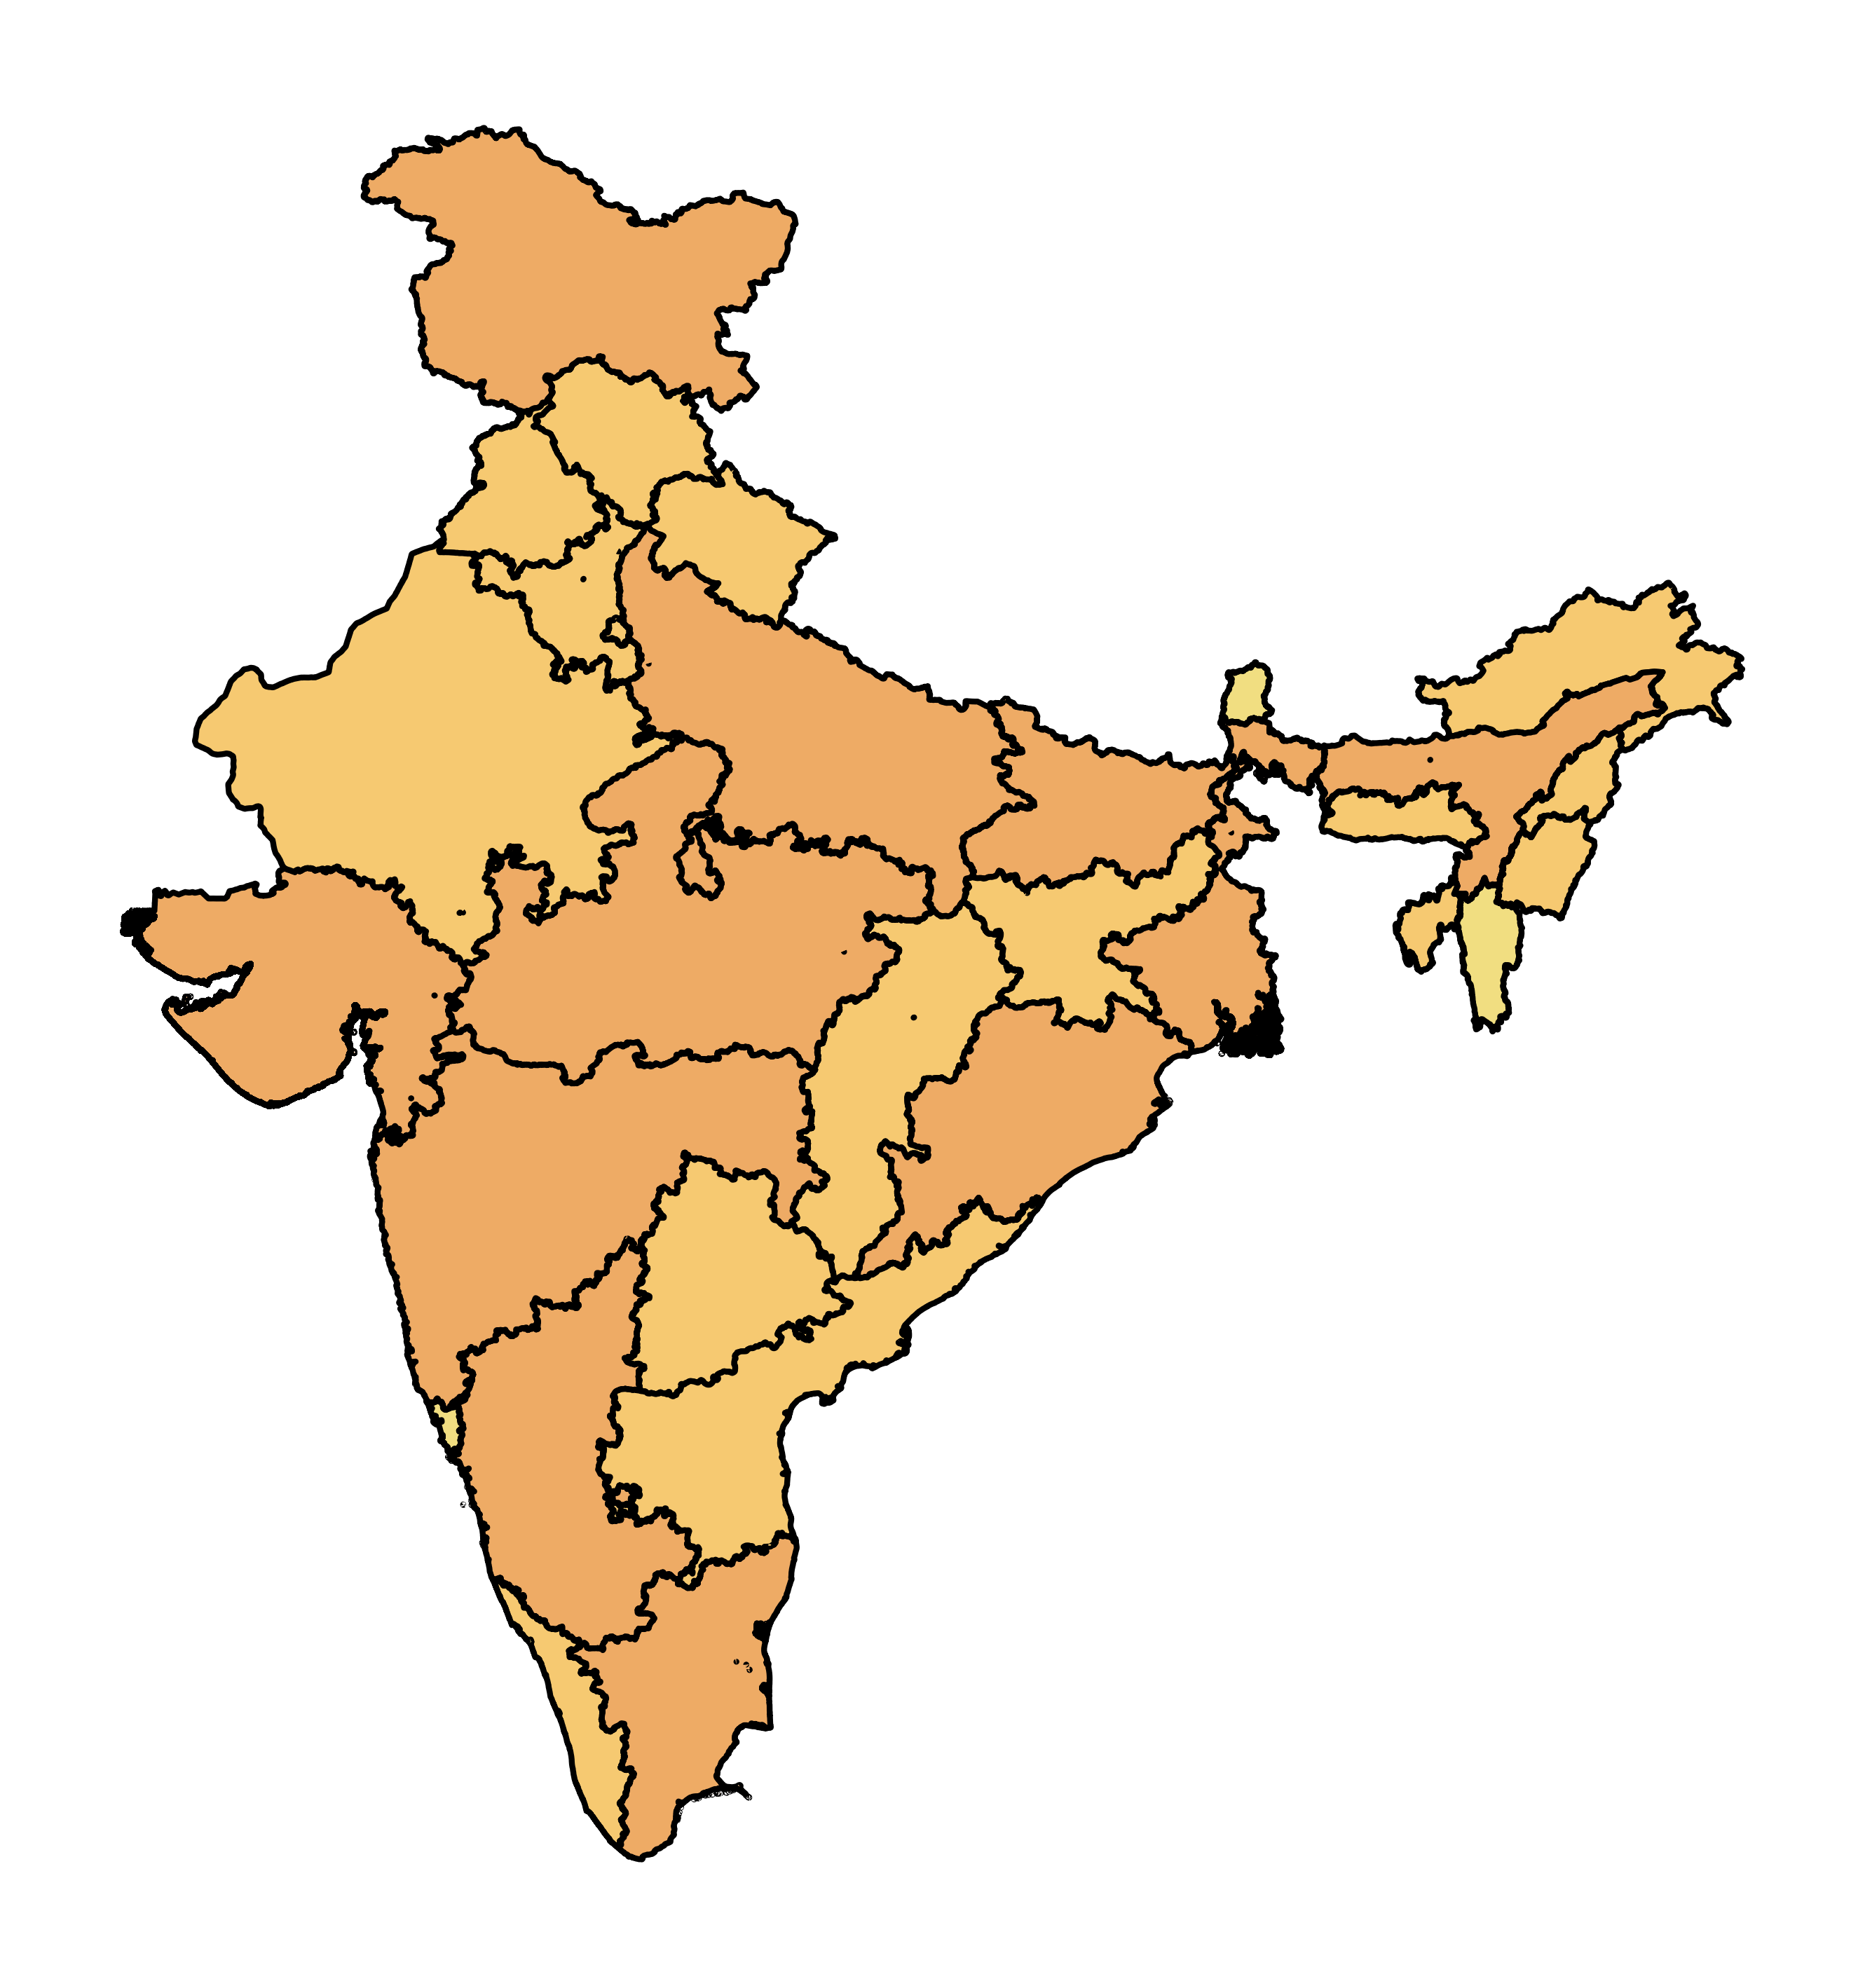

In [135]:
fig= plt.figure(figsize=(12,6))
ax= fig.add_subplot(111)
Ind_states.plot(column='events_log', ax=ax, cmap=events_cmap,edgecolor='black',
               vmin=0, vmax=5)
ax.axis('off');

In [136]:
fig.savefig('src/India_floods_states', dpi=500)

In [174]:
# clean states

IDs= Ind_states.apply(getIndByStates, axis=1, country='India', name='st_nm')

In [175]:
for i,ids in enumerate(IDs):
    df.loc[ids, 'STATE']= Ind_states.loc[i, 'st_nm']

# China province

In [139]:
CHN_prov= gpd.read_file('China_prov/chn_admbnda_adm1_ocha_2020.shp')

In [141]:
CHN_prov['events']= CHN_prov.apply(countByStates, axis=1, country='China')

In [143]:
CHN_prov['events_log']= np.log10(CHN_prov['events'])
CHN_prov.loc[CHN_prov.events==0, 'events_log']= np.nan

/home/allen/Documents/Programs/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


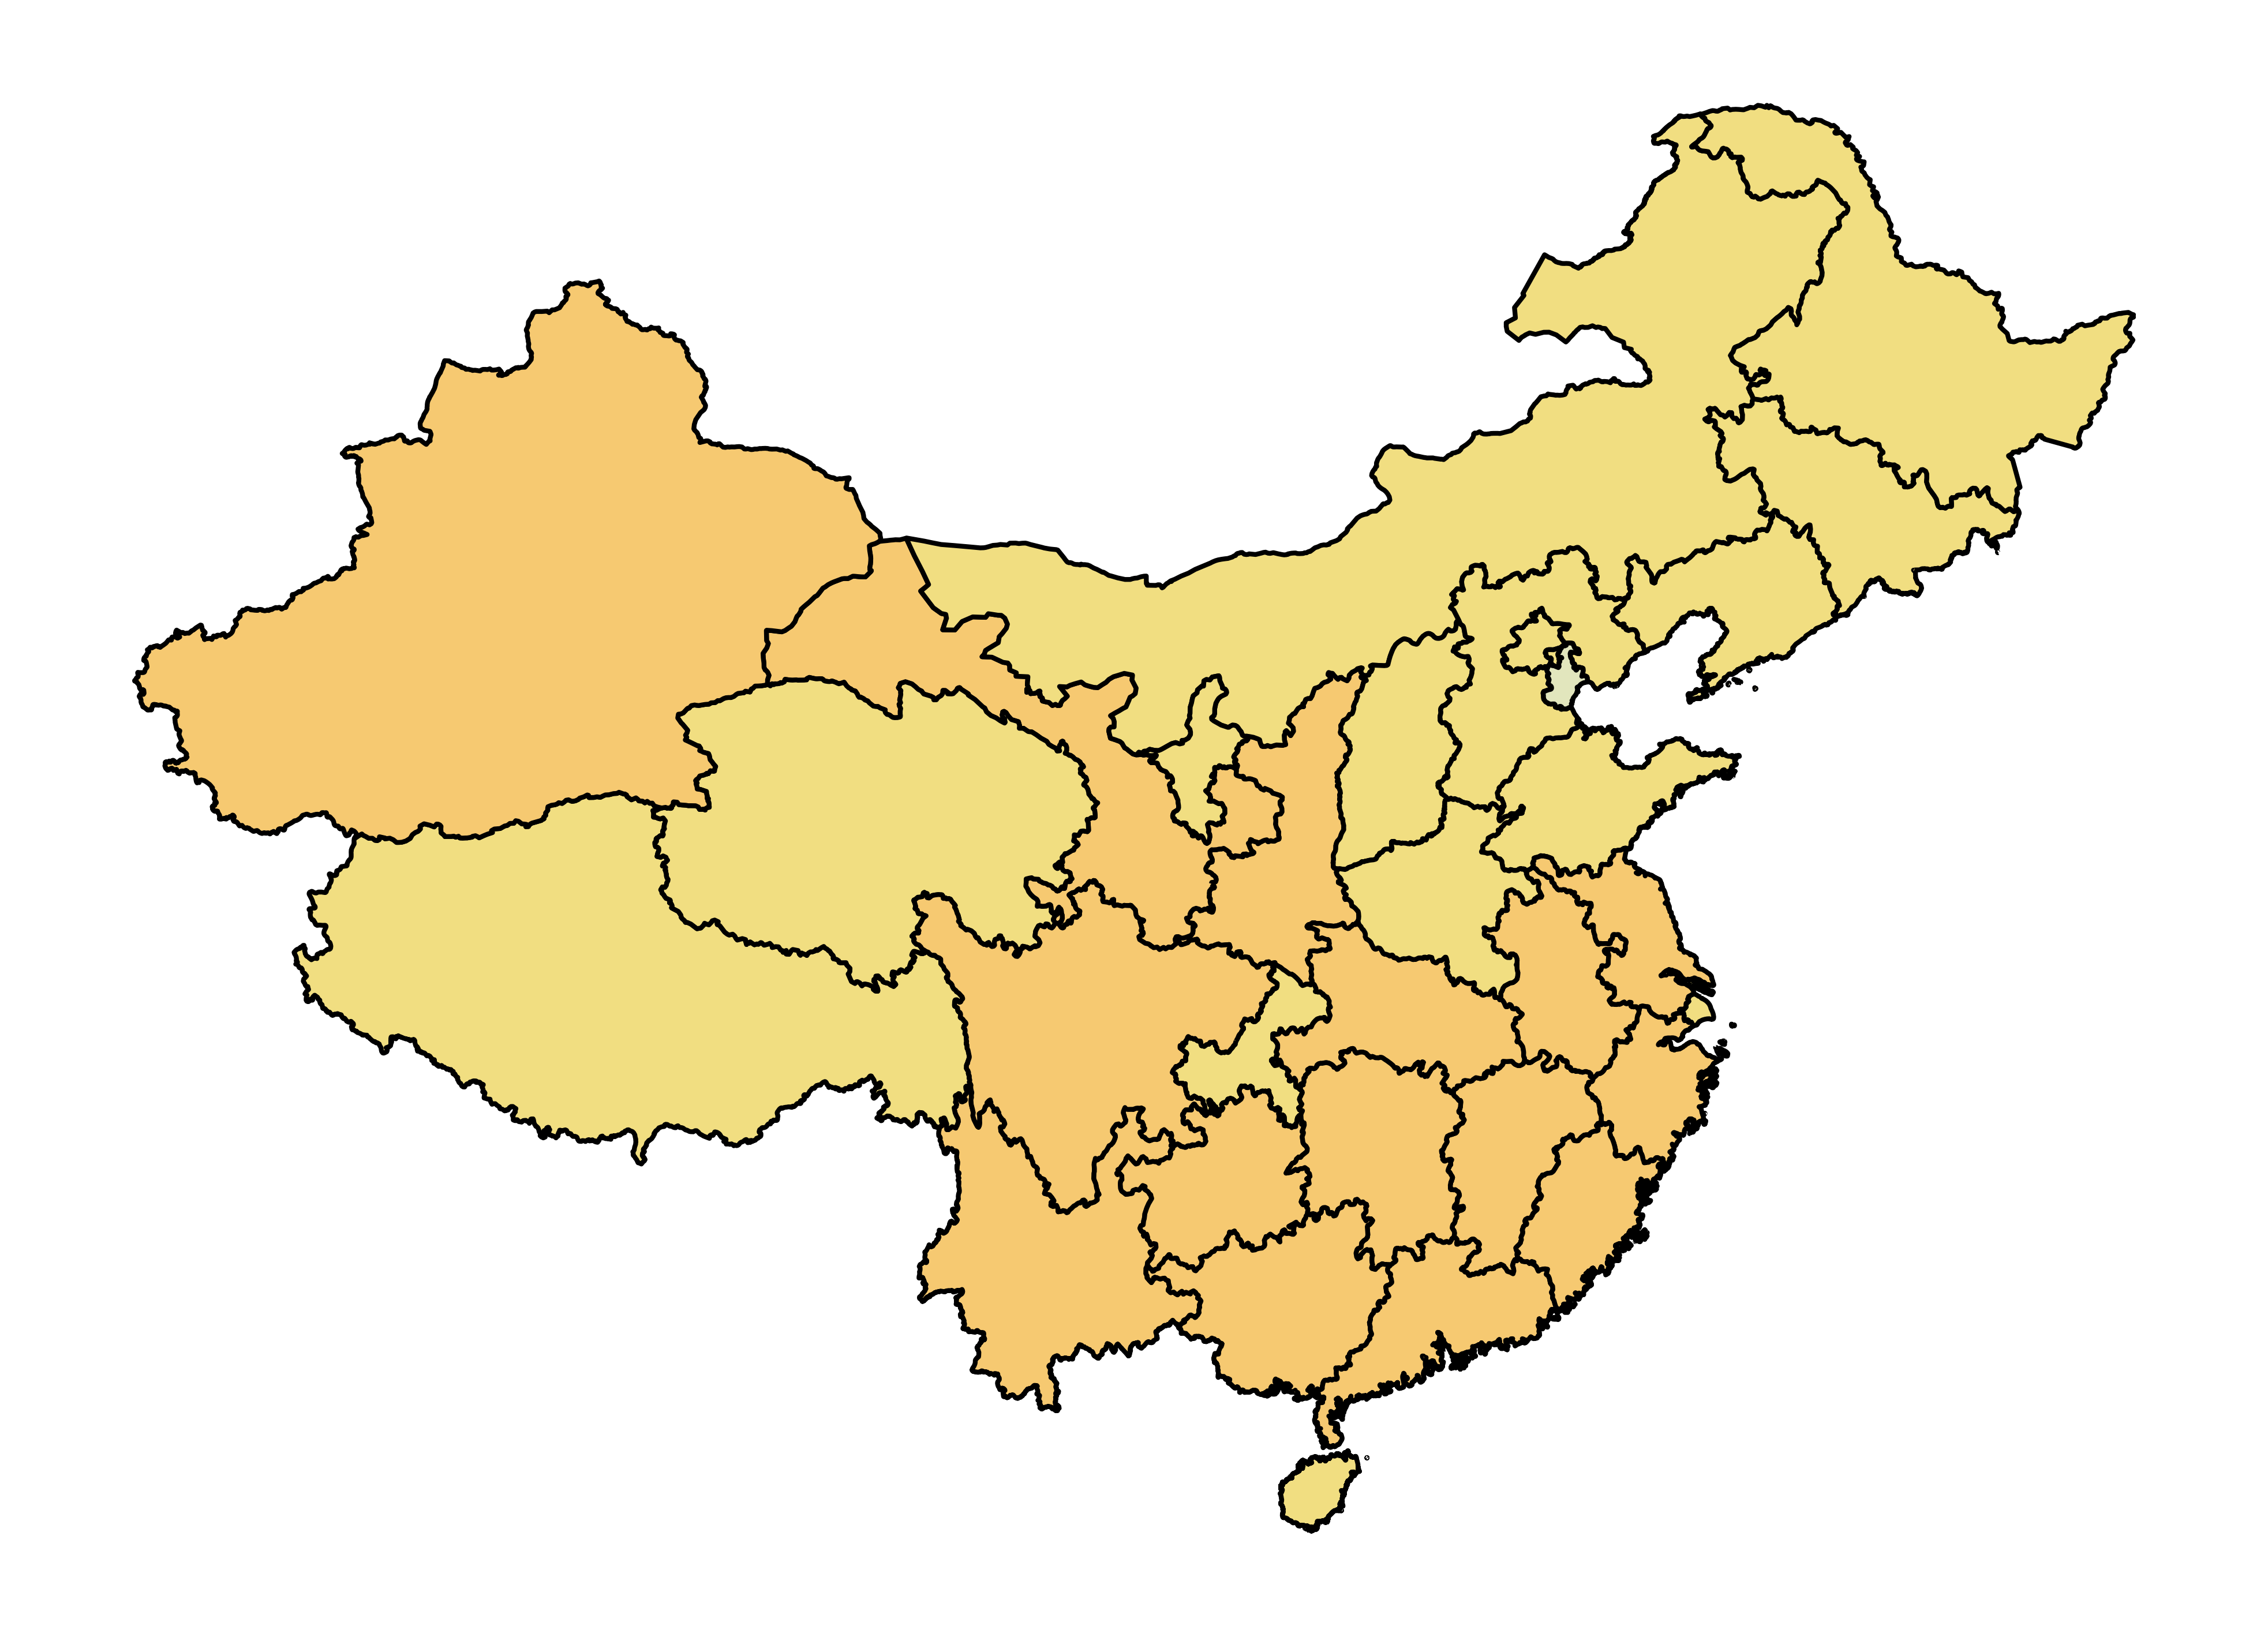

In [144]:
fig= plt.figure(figsize=(12,6))
ax= fig.add_subplot(111)
CHN_prov.plot(column='events_log', ax=ax, cmap=events_cmap,edgecolor='black',
               vmin=0, vmax=5)
ax.axis('off');

In [145]:
fig.savefig('src/China_floods_states.png', dpi=500)

In [181]:
# clean states
IDs= CHN_prov.apply(getIndByStates, axis=1, country='China')
for i,ids in enumerate(IDs):
    df.loc[ids, 'STATE']= CHN_prov.loc[i, 'ADM1_EN']

In [188]:
df.to_csv('merged_v0.43.csv')

# Get global watersheds

In [4]:
df= pd.read_csv('merged_v0.43.csv', index_col='ID', usecols=['ID','LON','LAT','DATE_BEGIN',
                                                              'COUNTRY','STATE'])

In [9]:
watersheds= ee.FeatureCollection('WWF/HydroSHEDS/v1/Basins/hybas_4').getInfo()['features']

In [11]:
watersheds[0]

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-91.80473497289246, 31.613247258035898],
    [-91.8035979374051, 31.601956831102118],
    [-91.80056576410288, 31.598041738542317],
    [-91.79908979430905, 31.59228952978082],
    [-91.7759916435315, 31.591045449257017],
    [-91.77139874136218, 31.58554286028173],
    [-91.7699138739444, 31.579750477329522],
    [-91.76054530533267, 31.5713986162359],
    [-91.75093150495672, 31.570132215487856],
    [-91.74109914506319, 31.559292190830483],
    [-91.74223180707476, 31.543622886329885],
    [-91.74526394279702, 31.53971226045297],
    [-91.7464010202381, 31.510291140388716],
    [-91.74943322324552, 31.506376009801556],
    [-91.74999951034454, 31.50416874873484],
    [-91.74999951034454, 31.49999949927065],
    [-91.74679787556583, 31.4990363315569],
    [-91.74519265366364, 31.493698810185084],
    [-91.7423075466364, 31.489636513791066],
    [-91.74089406020363, 31.475773227665993],
    [-91.7270307216248, 31

In [41]:
from shapely.geometry import shape, MultiPoint, Point

In [21]:
geom = [shape(watershed['geometry']) for watershed in watersheds]

In [22]:
geo_watersheds= gpd.GeoDataFrame({'geometry':geom})

for i,watershed in enumerate(watersheds):
#     print(shape(watershed['geometry']))
#     geo_watersheds.loc[i, 'geometry']=shape(watershed['geometry'])
    geo_watersheds.loc[i, 'ID']= watershed['properties']['HYBAS_ID']
    geo_watersheds.loc[i, 'UP_AREA']= watershed['properties']['UP_AREA']
    

In [45]:
gdf= gpd.GeoDataFrame(df, geometry= gpd.points_from_xy(df.LON, df.LAT))

In [57]:
def groupBySeason(watershed):
    try:
        masks= gdf.geometry.within(watershed.geometry)
#     gdf.loc[masks, 'Basin']= watershed.HYBAS_ID
    
        return gdf.loc[masks].index, watershed.ID
    except ValueError:
        return np.nan, np.nan
    

In [34]:
clean_df= df[(~pd.isna(df.LON)) & (~pd.isna(df.LAT))]

In [59]:
results= geo_watersheds.apply(groupBySeason, axis=1)

In [60]:
df['WATERSHED_ID']= np.nan

In [61]:
for ids, watershed_id in results:
    df.loc[ids, 'WATERSHED_ID']= watershed_id

In [64]:
#format database date
def format_date(x):
    if not pd.isna(x.DATE_BEGIN):
        if isinstance(x.DATE_BEGIN, int):
            date= str(x.DATE_BEGIN)
        elif isinstance(x.DATE_BEGIN, float):
            date= str(int(x.DATE_BEGIN))
        else:
            date= x.DATE_BEGIN
        if len(date)==4:
            return pd.to_datetime(date, format='%Y')
        elif len(date)==6:
            return pd.to_datetime(date, format='%Y%m')
        elif len(date)==8:
            return pd.to_datetime(date, format='%Y%m%d')
        elif len(date)==10:
            return pd.to_datetime(date, format='%Y%m%d%H')
        elif len(date)==12:
            return pd.to_datetime(date, format='%Y%m%d%H%M')
        elif len(date)==14:
            return pd.to_datetime(date, format='%Y%m%d%H%M%S')
        else:
            return np.nan
    else:
        return np.nan
    
dates= df.apply(format_date, axis=1)

In [85]:
for mon in range(1,13):
    geo_watersheds['%02d'%mon]= 0
    for i in range(len(geo_watersheds)):
        geo_watersheds.loc[i,'%02d'%mon]= len(df[(df.WATERSHED_ID==geo_watersheds.loc[i,'ID'])&\
                                                 (dates.dt.month==mon)])

In [91]:
def mapMostMonths(x):
    cases= np.array([x['%02d'%m] for m in range(1,13)])
    if (cases==0).all():
        return np.nan
    else:
        return np.argmax(cases)+1
        

geo_watersheds['most_cases_by_month']= geo_watersheds.apply(mapMostMonths,axis=1)

In [126]:
geo_watersheds.to_file('global_watershed_v4')

## Plots

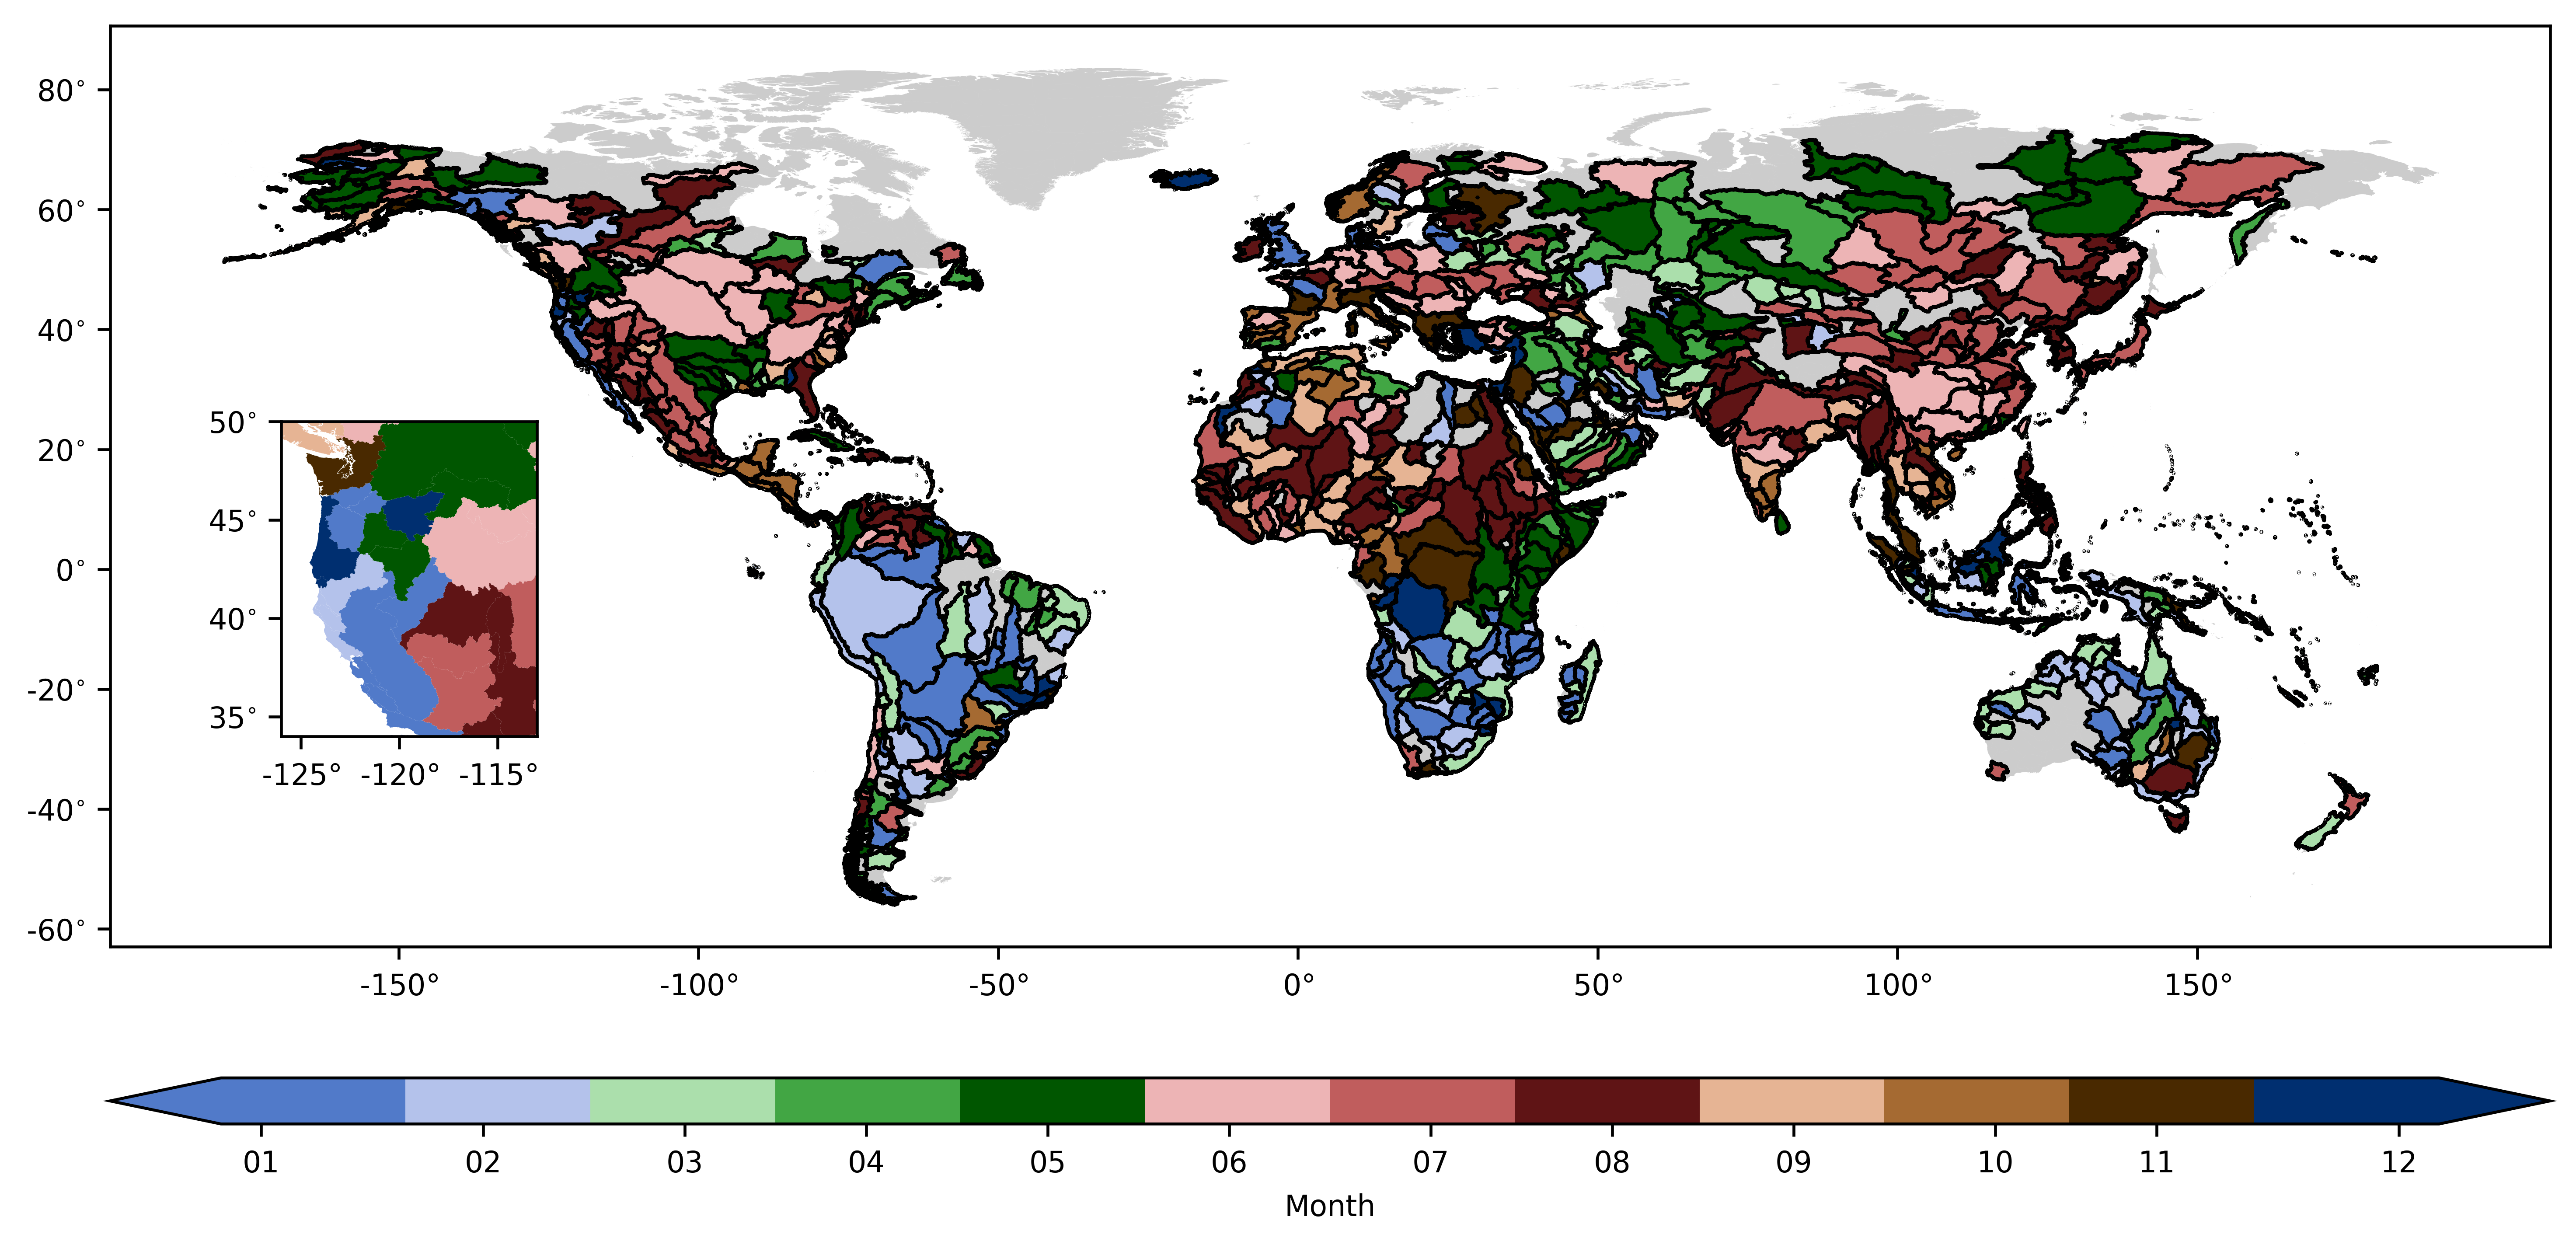

In [136]:
#("#002F70","#517AC9","#B4C2EB","#F6F6F6","#EDB4B5","#C05D5D","#5F1415")
colors= ["#517AC9","#B4C2EB","#ABDFAC","#42A644","#005600","#EDB4B5","#C05D5D","#5F1415",
        "#E6B494","#A56A32","#492900","#002F70"]
seasons_cmap= ListedColormap(colors)
fig= plt.figure(figsize=(12,6))
ax= fig.add_subplot(111)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)
geo_watersheds.plot( alpha=0.2, ax=ax)
geo_watersheds.plot(column='most_cases_by_month', cmap=seasons_cmap,ax=ax,cax=cax, legend=True,edgecolor='black',
           legend_kwds={'label': "Month",
                        'orientation': "horizontal",
                       "ticks": [1.2,2.3,3.3,4.2,5.1,6,7,7.9,8.8,9.8,10.6,11.8],
                       "extend": 'both'})
# cax.set_xticks([1,2.2,3.2,4.1,5.1,6,7,7.9,8.8,9.8,10.6,12])
cax.set_xticklabels(['%02d'%i for i in range(1,13)]);
ax.set_xticks(np.arange(-150,200,50))
ax.set_xticklabels(['%d$\degree$'%i for i in range(-150,200,50)])
ax.set_yticks(np.arange(-60,100,20))
ax.set_yticklabels(['%d$^{\circ}$'%i for i in range(-60,100,20)])
ax2=fig.add_axes([0.12,0.4,0.2,0.2])
geo_watersheds.plot(column='most_cases_by_month', cmap=seasons_cmap,ax=ax2)
ax2.set_xlim([-126.0,-113.0])
ax2.set_ylim([34,50])
ax2.set_xticks(np.arange(-125,-110,5))
ax2.set_xticklabels(['%d$\degree$'%i for i in range(-125,-110,5)])
ax2.set_yticks(np.arange(35,55,5))
ax2.set_yticklabels(['%d$^{\circ}$'%i for i in range(35,55,5)]);                   

In [137]:
fig.savefig('src/watersheds_by_month.png',dpi=500)

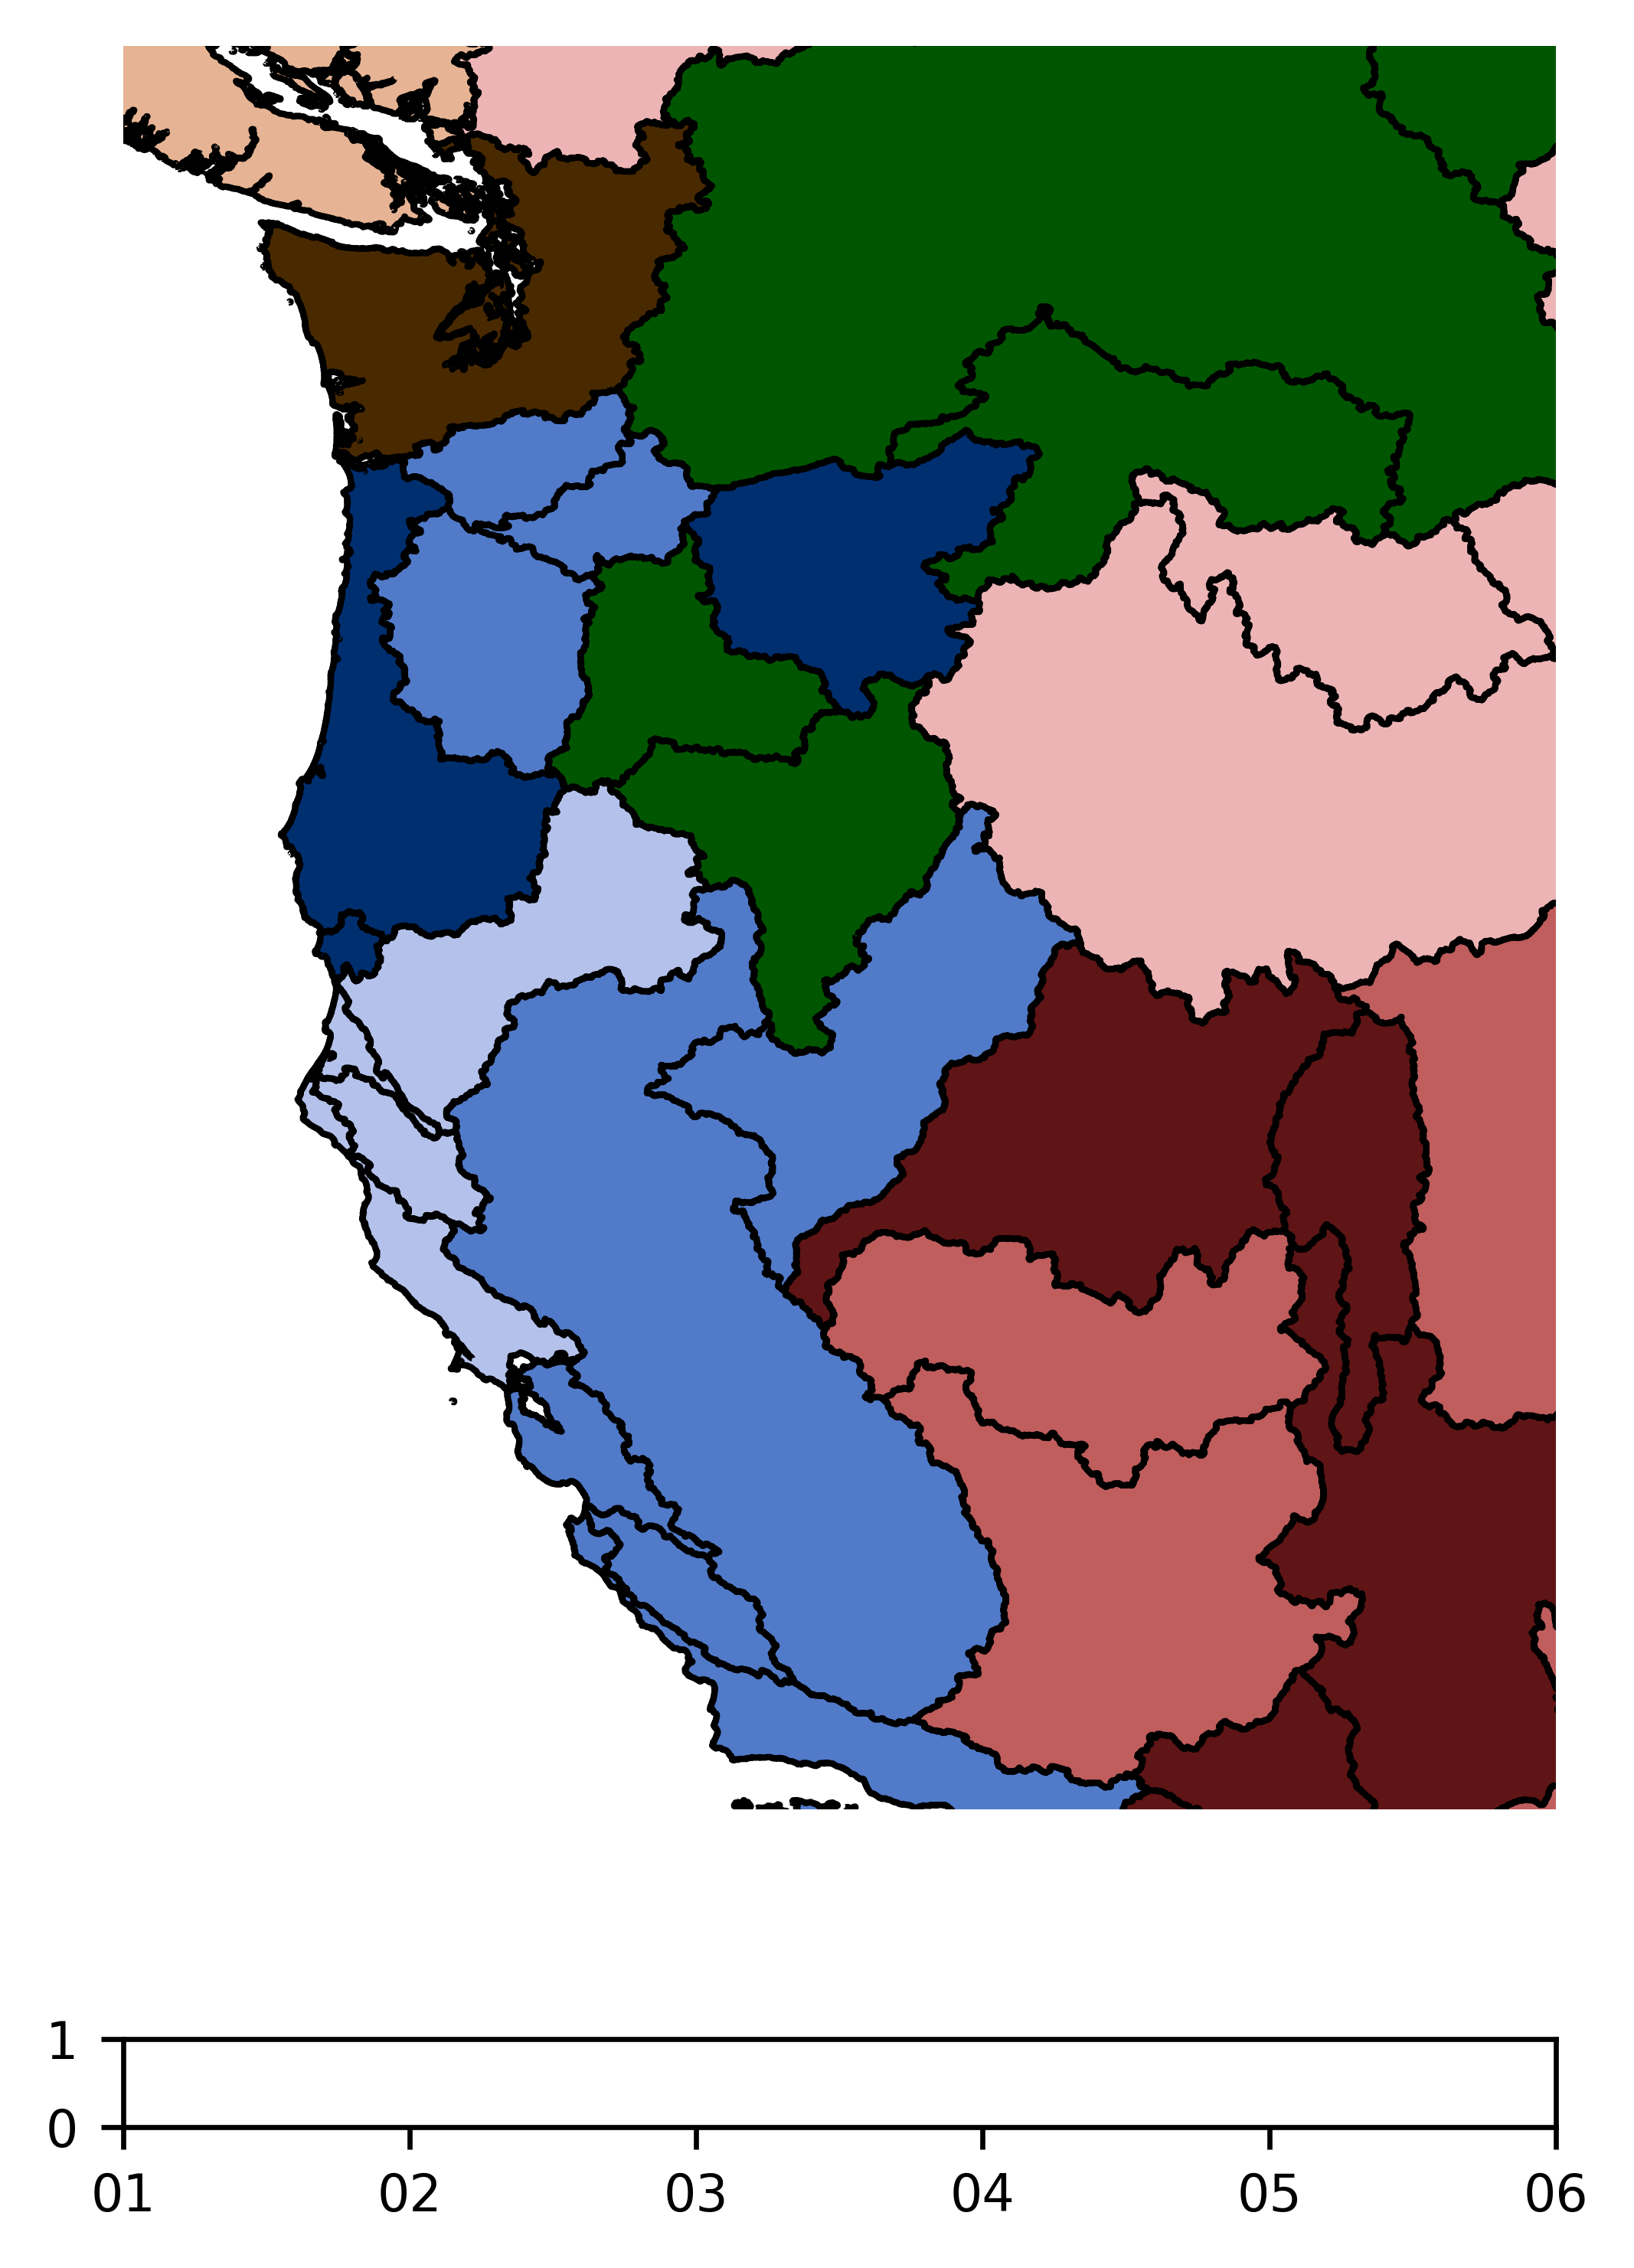

In [128]:
#("#002F70","#517AC9","#B4C2EB","#F6F6F6","#EDB4B5","#C05D5D","#5F1415")
colors= ["#517AC9","#B4C2EB","#ABDFAC","#42A644","#005600","#EDB4B5","#C05D5D","#5F1415",
        "#E6B494","#A56A32","#492900","#002F70"]
seasons_cmap= ListedColormap(colors)
fig= plt.figure(figsize=(12,6))
ax= fig.add_subplot(111)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("bottom", size="5%", pad=0.5)
geo_watersheds.plot( alpha=0.2, ax=ax)
geo_watersheds.plot(column='most_cases_by_month', cmap=seasons_cmap,ax=ax,cax=cax, legend=False,edgecolor='black',
           legend_kwds={'label': "Month",
                        'orientation': "horizontal",
                       "ticks": [1.2,2.3,3.3,4.2,5.1,6,7,7.9,8.8,9.8,10.6,11.8],
                       "extend": 'both'})
# cax.set_xticks([1,2.2,3.2,4.1,5.1,6,7,7.9,8.8,9.8,10.6,12])
cax.set_xticklabels(['%02d'%i for i in range(1,13)]);
ax.set_xticks(np.arange(-150,200,50))
ax.set_xticklabels(['%d$\degree$'%i for i in range(-150,200,50)])
ax.set_yticks(np.arange(-60,100,20))
ax.set_yticklabels(['%d$^{\circ}$'%i for i in range(-60,100,20)])
ax.set_xlim([-126.0,-113.0])
ax.set_ylim([34,50])
ax.axis('off');                   

# Impacts

In [200]:
df.to_csv('merged_v0.44.csv')

In [164]:
df['year']= dates.dt.year

In [180]:
df['FATALITY']= df.FATALITY.str.replace(',','').astype(float)

In [197]:
df.loc[df.SOURCE_DB=='NOAA Storm report', 'COUNTRY']= 'United States of America'

In [201]:
df[dates.dt.year>2020]

DATE_BEGIN  DATE_END  DURATION  LON  LAT COUNTRY  \
ID                                                          
149544  2.02607e+07  20260719       0.0  NaN  NaN     NaN   
149545   2.0281e+07  20281019       0.0  NaN  NaN     NaN   
149546  2.05007e+07  20500711       0.0  NaN  NaN     NaN   
149549  2.05608e+07  20560801       0.0  NaN  NaN     NaN   
149550  2.05609e+07  20560909       0.0  NaN  NaN     NaN   
149552  2.05709e+07  20570909       0.0  NaN  NaN     NaN   
149555  2.05811e+07  20581115       0.0  NaN  NaN     NaN   
149556  2.05907e+07  20590704       0.0  NaN  NaN     NaN   
149559  2.06011e+07  20601110       0.0  NaN  NaN     NaN   
149564  2.06109e+07  20610906       0.0  NaN  NaN     NaN   
149565   2.0611e+07  20611009       0.0  NaN  NaN     NaN   
149575  2.06709e+07  20670905       0.0  NaN  NaN     NaN   
149576  2.06806e+07  20680612       0.0  NaN  NaN     NaN   
149845  2.06707e+07  20670708       7.0  NaN  NaN     NaN   
149846  2.06707e+07  20670728       7.0  NaN  NaN     NaN   
149847  2.06708e+07  20670830      30.0  NaN  NaN     NaN   
149848  2.06709e+07  20670909       2.0  NaN  NaN     NaN   
149849  2.06806e+07  20680628       7.0  NaN  NaN     NaN   
149850  2.06806e+07  20680612       5.0  NaN  NaN     NaN   
149851  2.06807e+07  20680730      30.0  NaN  NaN     NaN   
149852  2.06807e+07  20680718       1.0  NaN  NaN     NaN   
149853  2.06808e+07  20680808       8.0  NaN  NaN     NaN   
149854   2.0681e+07  20681008       8.0  NaN  NaN     NaN   
149855   2.0681e+07  20681005       3.0  NaN  NaN     NaN   
149856  2.06811e+07  20681106       1.0  NaN  NaN     NaN   
149857  2.06906e+07  20690713      36.0  NaN  NaN     NaN   
149858  2.06907e+07  20690722       8.0  NaN  NaN     NaN   
149859  2.06907e+07  20690729       8.0  NaN  NaN     NaN   
149860  2.06908e+07  20690803       2.0  NaN  NaN     NaN   
149861  2.06908e+07  20690822      22.0  NaN  NaN     NaN   
149862  2.06909e+07  20690915      15.0  NaN  NaN     NaN   
149863  2.06908e+07  20690914      45.0  NaN  NaN     NaN   
149864  2.06909e+07  20690922       8.0  NaN  NaN     NaN   
149865   2.0691e+07  20691023       2.0  NaN  NaN     NaN   
149866   2.0691e+07  20691029      15.0  NaN  NaN     NaN   

                                                    STATE  \
ID                                                          
149544                                                NaN   
149545                                                NaN   
149546                                                NaN   
149549                                                NaN   
149550                                                NaN   
149552                                                NaN   
149555                                                NaN   
149556                                                NaN   
149559                                                NaN   
149564                                                NaN   
149565                                                NaN   
149575                                                NaN   
149576                                                NaN   
149845                                              Assam   
149846                                Maharastra, Gujarat   
149847                                      Uttar Pradesh   
149848  Odisha, Bihar, Uttar Pradesh, Madhya Pradesh, ...   
149849                                              Assam   
149850                                        West Bengal   
149851   Kerala, Rajasthan, Haryana, Uttar Pradesh, Bihar   
149852                                      Uttar Pradesh   
149853                                            Gujarat   
149854                                        West Bengal   
149855                                        West Bengal   
149856                                     Andhra Pradesh   
149857                                              Assam   
149858                                  Kar

In [199]:
df.drop('geometry', axis=1, inplace=True)

In [182]:
df.groupby('year').median()['FATALITY']

year
1900.0     300.0
1906.0       6.0
1909.0      72.0
1910.0    1379.0
1926.0       NaN
           ...  
2060.0       NaN
2061.0       NaN
2067.0       NaN
2068.0       NaN
2069.0       NaN
Name: FATALITY, Length: 94, dtype: float64

# Distance to river

In [140]:
df= pd.read_csv('merged_v0.43.csv', index_col='ID')

/home/allen/Documents/Programs/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (1,2,8,10,13,14,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [171]:
df.columns

Index(['DATE_BEGIN', 'DATE_END', 'DURATION', 'LON', 'LAT', 'COUNTRY', 'STATE',
       'LOCATION', 'AREA', 'FATALITY', 'DAMAGE', 'SEVERITY', 'SOURCE', 'CAUSE',
       'SOURCE_DB', 'SOURCE_ID', 'DESCRIPTION', 'geometry', 'slope', 'dem',
       'LULC', 'DISTANT_RIVER', 'CONT_AREA', 'DEPTH', 'year'],
      dtype='object')

In [144]:
distance= df.DISTANT_RIVER.unique()

In [148]:
groups= [0,0.5,1,2,5,10,20,50,100]

In [149]:
counts_within_group= [((distance>=groups[i]) & (distance<groups[i+1])).sum() for i in range(len(groups)-1)]

In [150]:
counts_within_group

[12867, 13826, 50670, 11660, 3925, 905, 30, 0, 0]

In [161]:
from scipy.interpolate import interpn
from scipy.stats import gaussian_kde
def scatter(x,y,**figkwargs):
    '''
    Make density scatter plot
    Args:
    ---------------
    :x - numpy.array object (None, 1)
    :y - numpy.array object (None, 1)
    Returns:
    ---------------
    :fig - matplotlib.pyplot object
    :axes - axes for the figure
    '''
    masks= (~np.isnan(x) & ~np.isinf(x)) & (~np.isnan(y))
    x= x[masks]
    y= y[masks]
    s= figkwargs.pop('s', 100)
    _max= max(x.max(), y.max())
    _min= min(x.min(), y.min())
    fig= plt.figure()
    axes= fig.add_subplot()
    data, x_e, y_e= np.histogram2d(x, y, bins=50)
    z= interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) ,
        data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )
    idx= z.argsort() #move high density forward
    x, y, z= x[idx], y[idx], z[idx]
    ax= axes.scatter(x, y, c= z, s=200, edgecolor= '', cmap='jet', **figkwargs)
    axes.set_aspect('equal', 'box')
    axes.plot([_min, _max],[_min, _max], c='r')
    cb= plt.colorbar(orientation='vertical', mappable=ax)

    return fig, axes

/home/allen/Documents/Programs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/home/allen/Documents/Programs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


(<Figure size 1980x1500 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f19bc4c7910>)

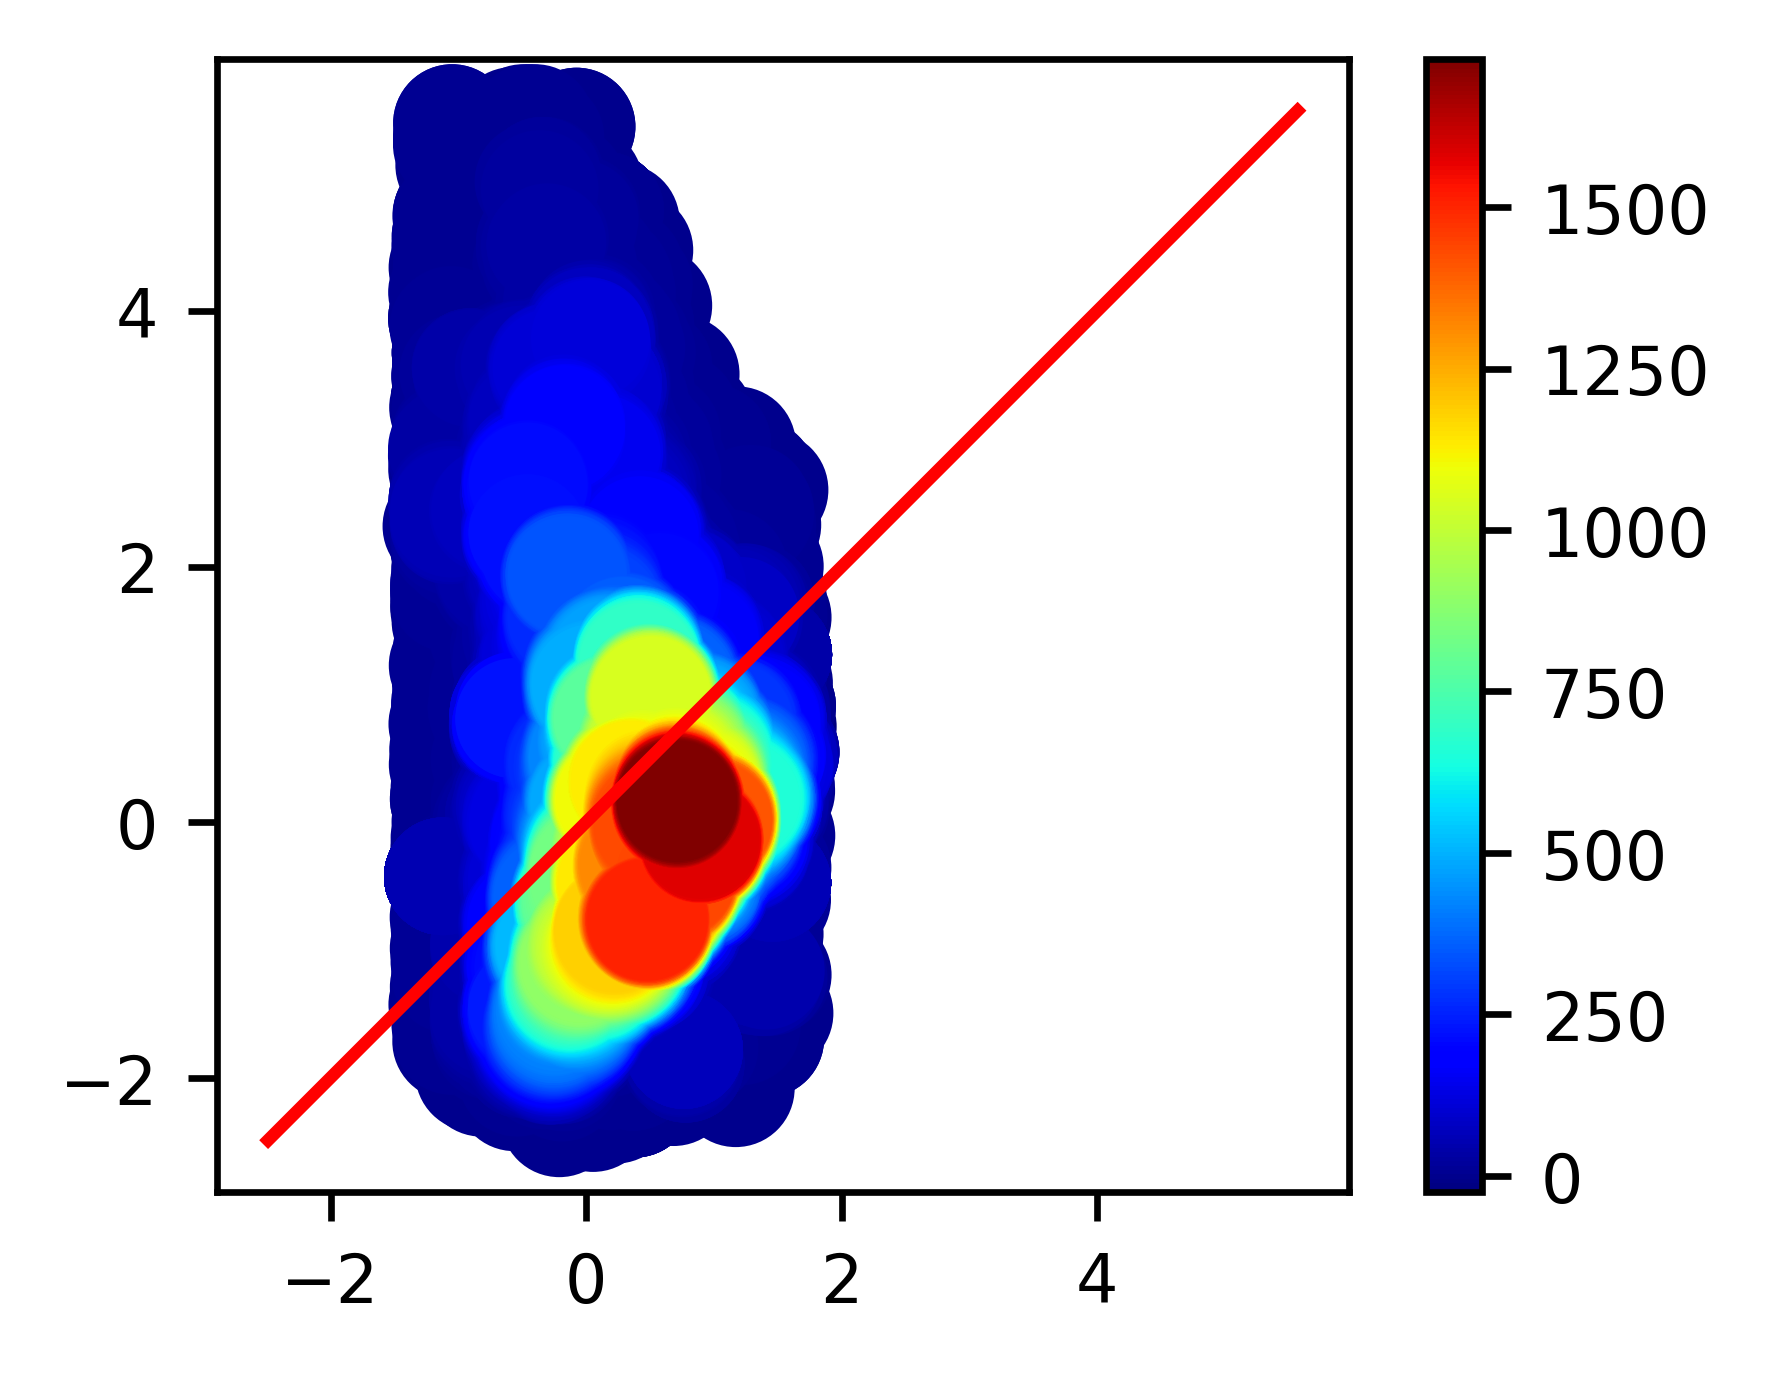

In [163]:
scatter(np.log10(df.DISTANT_RIVER.values), np.log10(df.CONT_AREA.values))